(1000, 1000)


/var/folders/cs/f0kzlkp96y3_w0tw04n190tr0000gn/T/ipykernel_36242/2037548392.py:43: DeprecationWarning: Use of the "cond" and "rcond" keywords are deprecated and will be removed in future versions of SciPy. Use "atol" and "rtol" keywords instead
  A = sp.linalg.pinv(G_00 + epsilon*np.eye(m), rcond=1e-15) @ G_10


(1000, 1000)


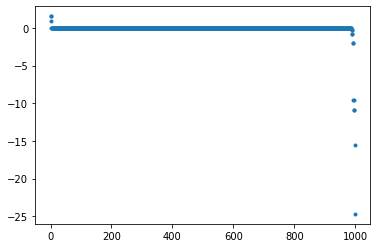

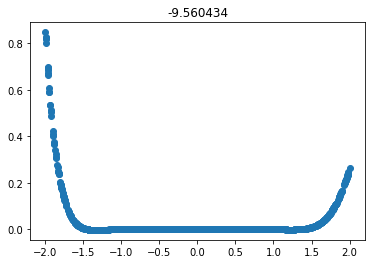

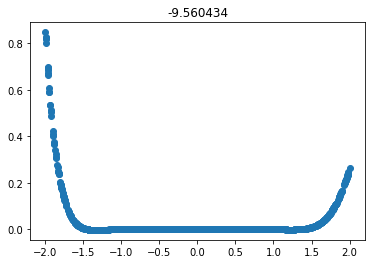

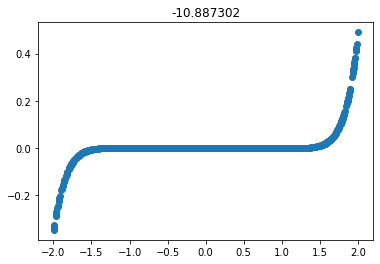

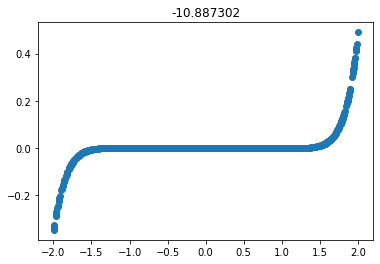

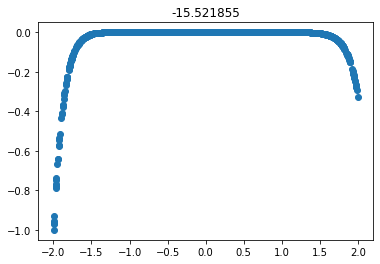

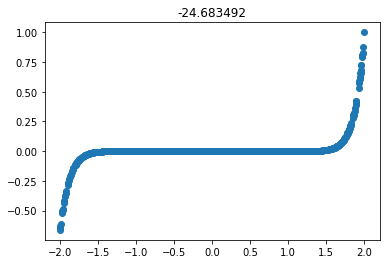

In [21]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # noqa: F401 unused import

import d3s.domain as domain
import d3s.observables as observables
import d3s.kernels as kernels
import d3s.algorithms as algorithms
import d3s.systems as systems
from d3s.tools import printVector, printMatrix 

def b(x):
    return -alpha*x
def sigma(x):
    return np.sqrt(2/beta)*np.ones((1, 1, x.shape[1]))

#%% direct kernelization for kernels with finite-dimensional feature space
alpha = 1
beta = 4
bounds = np.array([[-2, 2]])
boxes = np.array([100])
Omega = domain.discretization(bounds, boxes)
m=1000
X = Omega.rand(m)
Y = b(X)
Z = sigma(X) 
epsilon = 0.1
S = np.einsum('ijk,ljk->ilk', Z, Z) # sigma \cdot sigma^T
psi = observables.monomials(15)
PsiX = psi(X)
dPsiY = np.einsum('ijk,jk->ik', psi.diff(X), Y)
if not (Z is None): # stochastic dynamical system
    n = PsiX.shape[0] # number of basis functions
    ddPsiX = psi.ddiff(X) # secplond-order derivatives
    S = np.einsum('ijk,ljk->ilk', Z, Z) # sigma \cdot sigma^T
    for i in range(n):
        dPsiY[i, :] += 0.5*np.sum(ddPsiX[i, :, :, :] * S, axis=(0,1) )

G_00 = PsiX.T @ PsiX
G_10 = dPsiY.T @ PsiX
print(G_00.shape)
A = sp.linalg.pinv(G_00 + epsilon*np.eye(m), rcond=1e-15) @ G_10
d, V = algorithms.sortEig(A, evs=m, which='SM')
V = G_00 @ V
print(V.shape)
'''
monomial 
vs 
kernel
'''

plt.figure()
plt.plot(np.real(d), '.')

for i in range(m-6, m):
    plt.figure()
    plt.scatter(X, np.real(V[:, i]/np.amax(abs(V[:, i]))))
    plt.title('%f' % np.real(d[i]))